In [1]:
import os
from dotenv import load_dotenv
import json
import random
import matplotlib.pyplot as plt
import numpy as np
import asyncio
import pandas as pd

from sqlalchemy import select, func
from sqlalchemy.orm import joinedload

from benchmarklib import BenchmarkDatabase
from clique import CliqueProblem, CliqueTrial, CliqueOracleTrial
from benchmarklib.compilers import CompileType, XAGCompiler, QCFCompiler
from benchmarklib.pipeline.synthesis import QuantumMPC

from benchmarklib.analysis import analyze_success_rates
from benchmarklib.compilers import TruthTableCompiler
from benchmarklib.pipeline import PipelineCompiler

from compiler_configs import compiler_qmpc_ai_test, compiler_qmpc_standard

from qiskit_ibm_runtime import QiskitRuntimeService

In [2]:
service = QiskitRuntimeService()
benchmark_db = BenchmarkDatabase("clique.db", CliqueProblem, CliqueTrial)

In [7]:
oracle_db = BenchmarkDatabase("clique.db", CliqueProblem, CliqueOracleTrial)
await oracle_db.update_all_pending_results(service)

In [3]:
# run this cell to load the job results for all trials that are waiting pending job results
await benchmark_db.update_all_pending_results(service, batch_size=1)

In [ ]:

    
#analyze_success_rates(benchmark_db, (compiler_qmpc_ai_test, QCFCompiler(), XAGCompiler(), QuantumMPC()), "plots")


In [9]:
def get_probability_data(trial_db, compiler_name=None):
    n_data = []
    grover_iterations_data = []
    probability_data = []

    for n in range(2, 21):
        for grover_iterations in range(1, 6):
            print(f"(n, grover_iterations) = ({n}, {grover_iterations})")
            trials = trial_db.query(
                select(CliqueTrial).join(CliqueTrial.problem).where(
                    CliqueProblem.nodes == n,
                    CliqueTrial.compiler_name == compiler_name,
                    CliqueTrial.grover_iterations == grover_iterations
                )
                .options(joinedload(CliqueTrial.problem))
            )

            if len(trials) == 0:
                print(f"Warning: no results for {n} variables, complexity {grover_iterations}; skipping")
                continue

            success_rates = np.zeros(len(trials))
            expected_success_rates = np.zeros(len(trials))

            for i, trial in enumerate(trials):
                success_rates[i] = trial.calculate_success_rate()
                expected_success_rates[i] = trial.calculate_expected_success_rate()
            
            n_data.append(n)
            grover_iterations_data.append(grover_iterations)
            probability_data.append(np.mean(success_rates / expected_success_rates))
            print(f"Mean success rate over expected: {probability_data[-1]}")
    
    return n_data, grover_iterations_data, probability_data

def plot_probability_data(n_data, grover_iterations_data, probability_data, title, filepath=None):
    
    df = pd.DataFrame({
        'num_vertices': n_data,
        'grover_iterations': grover_iterations_data,
        'prob': probability_data
    })
    grid = df.pivot(index='grover_iterations', columns='num_vertices', values='prob')
    grid = grid.sort_index(ascending=True)

    plt.figure(figsize=(12, 10))
    # set NaN values to white since we do not have a full rectangle of data
    cmap = plt.cm.get_cmap("RdYlGn").copy()
    cmap.set_bad(color="white")

    plt.figure(figsize=(10, 8))
    plt.pcolormesh(
        grid.columns,
        grid.index,
        grid.values,
        cmap=cmap,
        shading='nearest',
        vmin=0,
        vmax=0.2
    )

    plt.xticks(np.arange(min(n_data), max(n_data) + 1, 1))
    plt.yticks(np.arange(min(grover_iterations_data), max(grover_iterations_data) + 1, 1))

    plt.xlabel('Vertex Count')
    plt.ylabel('Grover Iterations')
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label(f'Mean Success Rate', rotation=270, labelpad=15)
    if filepath is not None:
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.show()

def plot_probability_data_side_by_side(n_data, grover_iterations_data, probability_data1, probability_data2, title1, title2, filepath=None):
    df1 = pd.DataFrame({
        'num_vertices': n_data,
        'grover_iterations': grover_iterations_data,
        'prob': probability_data1
    })
    grid1 = df1.pivot(index='grover_iterations', columns='num_vertices', values='prob')
    grid1 = grid1.sort_index(ascending=True)

    df2 = pd.DataFrame({
        'num_vertices': n_data,
        'grover_iterations': grover_iterations_data,
        'prob': probability_data2
    })
    grid2 = df2.pivot(index='grover_iterations', columns='num_vertices', values='prob')
    grid2 = grid2.sort_index(ascending=True)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    plot1 = axes[0].pcolormesh(
        grid1.columns, grid1.index, grid1.values,
        cmap='RdYlGn', shading='auto'
    )
    axes[0].set_xticks(np.arange(min(n_data), max(n_data) + 1, 1))
    axes[0].set_yticks(np.arange(min(grover_iterations_data), max(grover_iterations_data) + 1, 1))
    axes[0].set_xlabel('Vertex Count')
    axes[0].set_ylabel('Grover Iterations')
    axes[0].set_title(title1)

    plot2 = axes[1].pcolormesh(
        grid2.columns, grid2.index, grid2.values,
        cmap='RdYlGn', shading='auto'
    )
    axes[1].set_xticks(np.arange(min(n_data), max(n_data) + 1, 1))
    axes[1].set_yticks(np.arange(min(grover_iterations_data), max(grover_iterations_data) + 1, 1))
    axes[1].set_xlabel('Vertex Count')
    axes[1].set_ylabel('Grover Iterations')
    axes[1].set_title(title2)

    cbar = fig.colorbar(plot1, ax=axes.ravel().tolist(), shrink=0.95)
    cbar.set_label(f'Mean Success Rate', rotation=270, labelpad=15)
    if filepath is not None:
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.show()


def plot_probability_difference(n_data, grover_iterations_data, probability_data1, probability_data2, title, filepath=None):
    difference_data = [p1 - p2 for p1, p2 in zip(probability_data1, probability_data2)]
    df = pd.DataFrame({
        'num_vertices': n_data,
        'grover_iterations': grover_iterations_data,
        'diff': difference_data
    })
    grid = df.pivot(index='grover_iterations', columns='num_vertices', values='diff')
    grid = grid.sort_index(ascending=True)
    plt.figure(figsize=(12, 10))
    plt.pcolormesh(
        grid.columns, grid.index, grid.values,
        cmap='RdBu_r', shading='auto', vmin=-0.2, vmax=0.2
    )
    plt.xticks(np.arange(min(n_data), max(n_data) + 1, 1))
    plt.yticks(np.arange(min(grover_iterations_data), max(grover_iterations_data) + 1, 1))

    plt.xlabel('Vertex Count')
    plt.ylabel('Grover Iterations')
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label(f'Difference in Success Rate', rotation=270, labelpad=15)
    if filepath is not None:
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.show()

In [10]:
data = {}
compiler_list = [QCFCompiler(), XAGCompiler(), compiler_qmpc_ai_test, compiler_qmpc_standard]
for compiler in compiler_list:
    n_data, grover_iterations_data, probability_data = get_probability_data(benchmark_db, compiler_name=compiler.name)
    data[compiler.name] = {
        'n_data': n_data,
        'grover_iterations_data': grover_iterations_data,
        'probability_data': probability_data
    }

(n, grover_iterations) = (2, 1)
(n, grover_iterations) = (2, 2)
(n, grover_iterations) = (2, 3)
(n, grover_iterations) = (2, 4)
(n, grover_iterations) = (2, 5)
(n, grover_iterations) = (3, 1)
Mean success rate over expected: 0.3849466666666666
(n, grover_iterations) = (3, 2)
Mean success rate over expected: 0.15444628099173555
(n, grover_iterations) = (3, 3)
(n, grover_iterations) = (3, 4)
(n, grover_iterations) = (3, 5)
(n, grover_iterations) = (4, 1)
Mean success rate over expected: 0.2575831550246213
(n, grover_iterations) = (4, 2)
Mean success rate over expected: 0.11660676033713584
(n, grover_iterations) = (4, 3)
Mean success rate over expected: 0.06917579086046254
(n, grover_iterations) = (4, 4)
(n, grover_iterations) = (4, 5)
(n, grover_iterations) = (5, 1)
Mean success rate over expected: 0.22097618469304212
(n, grover_iterations) = (5, 2)
Mean success rate over expected: 0.10385827021547159
(n, grover_iterations) = (5, 3)
Mean success rate over expected: 0.05784440290240176
(n

/tmp/ipykernel_28636/3572316281.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("RdYlGn").copy()


<Figure size 1200x1000 with 0 Axes>

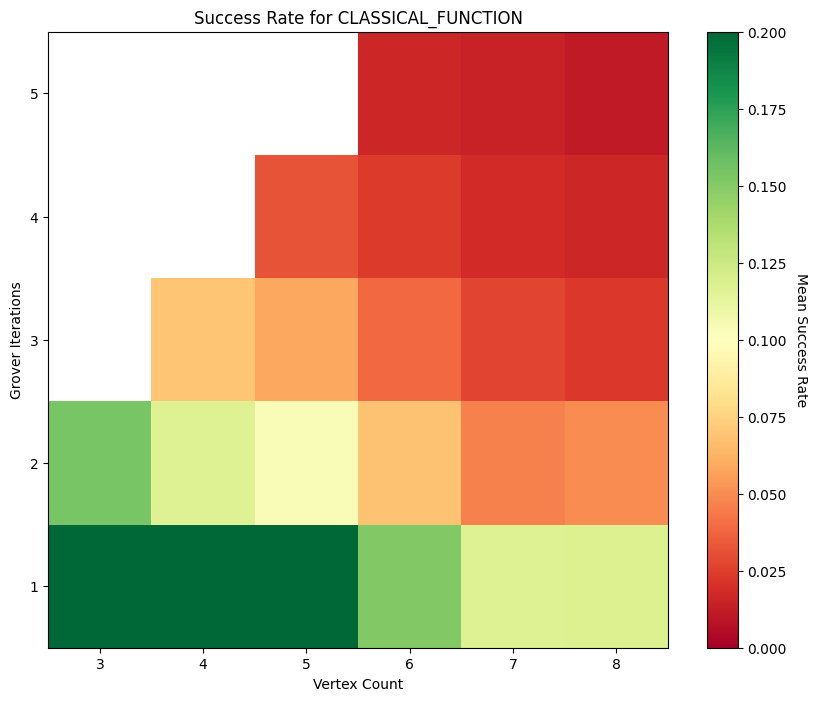

<Figure size 1200x1000 with 0 Axes>

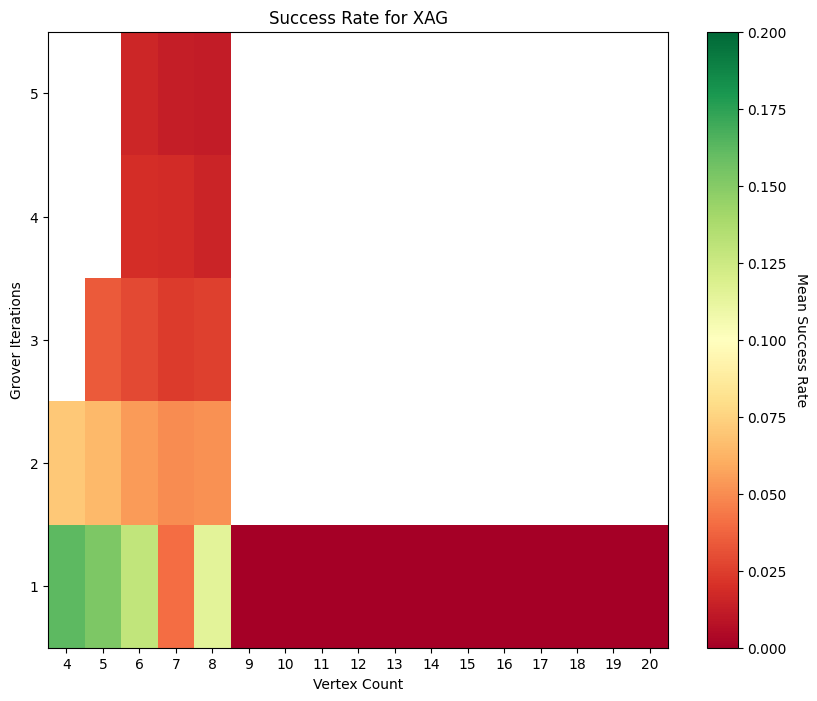

<Figure size 1200x1000 with 0 Axes>

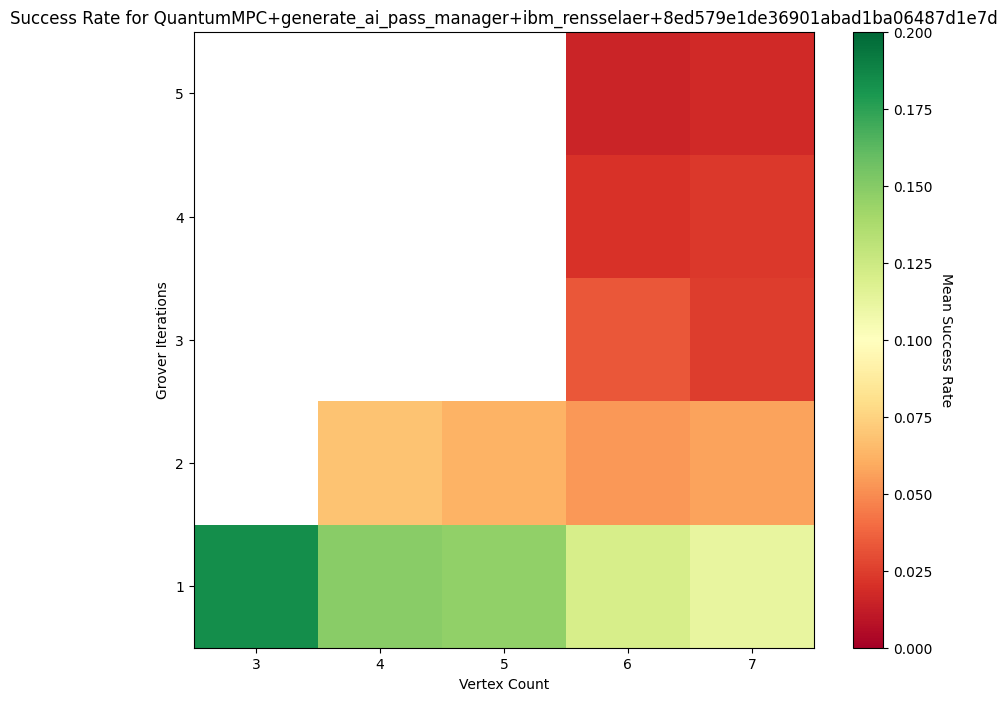

<Figure size 1200x1000 with 0 Axes>

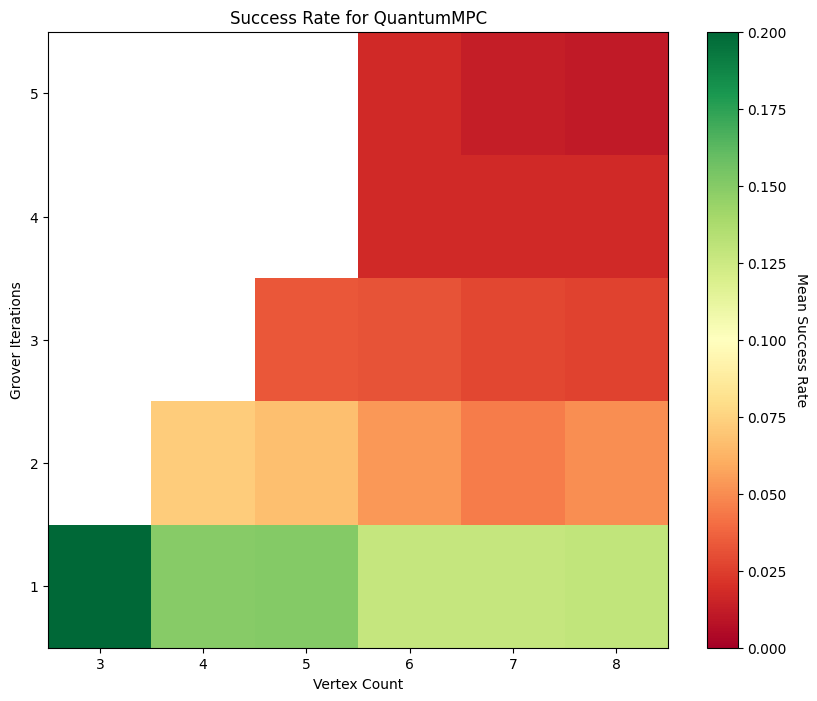

In [11]:
for compiler in compiler_list:
    plot_probability_data(
        data[compiler.name]['n_data'],
        data[compiler.name]['grover_iterations_data'],
        data[compiler.name]['probability_data'],
        title=f"Success Rate for {compiler.name}",
        filepath=f"plots/CLIQUE_mean_success_rates_{compiler.name}.png"
    )

In [61]:
n_data = []
num_solutions_data = []
success_data = []
for trial in oracle_db.query(select(CliqueOracleTrial).where(CliqueOracleTrial.compiler_name != "XAG").options(joinedload(CliqueOracleTrial.problem))):
    n_data.append(trial.problem.nodes)
    num_solutions_data.append(trial.problem.clique_counts[trial.problem.target_clique_size] / (2**trial.problem.nodes))
    if trial.is_failed:
        success_data.append(0.0)
    else:
        success_data.append(1 if trial.calculate_success_rate() > 0.2 else 0)

Text(0, 0.5, 'Number of Solutions / 2^n')

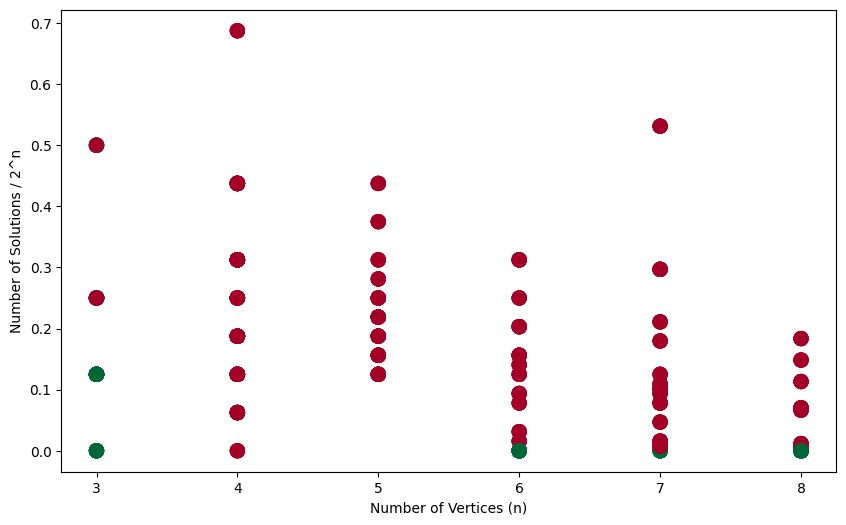

In [62]:
plt.figure(figsize=(10, 6))
plt.scatter(n_data, num_solutions_data, c=success_data, cmap='RdYlGn', s=100)
plt.xlabel('Number of Vertices (n)')
plt.ylabel('Number of Solutions / 2^n')

In [1]:
n_data = []
depth_data = []
success_data = []
for trial in oracle_db.query(select(CliqueOracleTrial).where(CliqueOracleTrial.compiler_name != "XAG").options(joinedload(CliqueOracleTrial.problem))):
    n_data.append(trial.problem.nodes)
    depth_data.append(trial.circuit_depth)
    if trial.is_failed:
        success_data.append(0.0)
    else:
        success_data.append(min(trial.calculate_success_rate() / 0.5, 1.0))
        

NameError: name 'oracle_db' is not defined

Text(0, 0.5, 'Circuit Depth (log scale)')

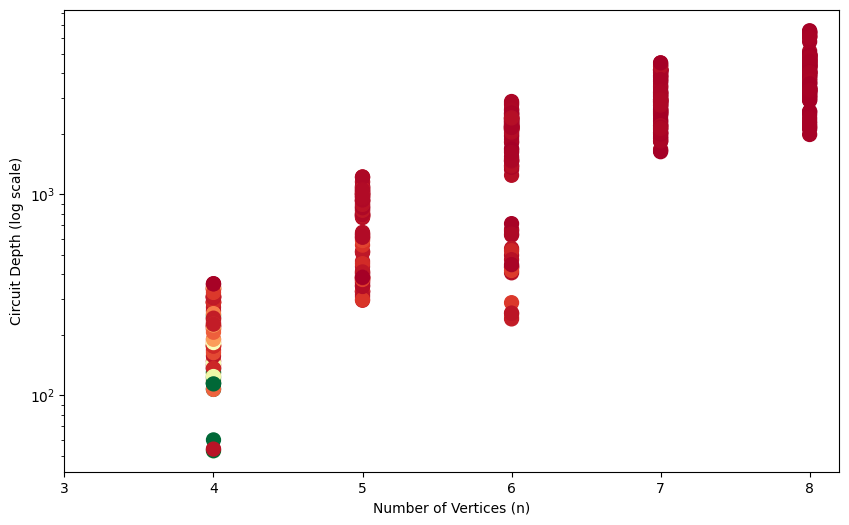

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(n_data, depth_data, c=success_data, cmap='RdYlGn', s=100)
plt.xticks(range(min(n_data), max(n_data)+1))
plt.yscale('log')
plt.xlabel('Number of Vertices (n)')
plt.ylabel('Circuit Depth (log scale)')